In [24]:
#importing libraries
import pandas as pd
import numpy as np
import pycountry
import os
import seaborn as sns
from helper_functions import load_ratings, load_breweries, load_users, add_user_and_brewery_location, drop_breweries_with_less_than_n_reviews, get_average_rating_and_count_per_brewery, get_average_per_country, plot_world_map, drop_countries_with_less_than_n_reviews, keep_only_countries_in_list_and_merge_all_dfs
import matplotlib.pyplot as plt

In [25]:
#Dataset directories
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
BA_DIR = os.path.join(DATA_DIR, 'BeerAdvocate/')
RB_DIR = os.path.join(DATA_DIR, 'RateBeer/')
MATCHED_BEER_DIR = os.path.join(DATA_DIR, "matched_beer_data/")

In [26]:
#Dataset loading
ratings_data = load_ratings(os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_rb.txt'), os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_ba.txt'))
breweries_data = load_breweries(os.path.join(RB_DIR, 'breweries.csv'), os.path.join(BA_DIR, 'breweries.csv'))
users_data = load_users(os.path.join(RB_DIR, 'users.csv'), os.path.join(BA_DIR, 'users.csv'))
breweries_data['id'] = breweries_data['id'].astype(int)
ratings_data['brewery_id'] = ratings_data['brewery_id'].astype(int)
ratings_data['beer_id'] = ratings_data['beer_id'].astype(int)

In [27]:
brewery_id_to_country = breweries_data.set_index("id")["location"].to_dict()
beer_id_to_brewery_id = ratings_data.set_index("beer_id")["brewery_id"].to_dict()
beer_country_dict = {}
for beer_id, brewery_id in beer_id_to_brewery_id.items():
    if brewery_id in brewery_id_to_country:
        country = brewery_id_to_country[brewery_id]
        beer_country_dict[beer_id] = country

In [28]:
count_reviews = ratings_data.groupby(['beer_id'])['rating'].count().to_frame().reset_index().rename(columns={'rating': 'count'})
count_reviews["country"] = count_reviews['beer_id'].map(brewery_id_to_country)

In [29]:
count_rating_per_country = count_reviews.groupby('country')['count'].sum().reset_index()

In [30]:
ratings_data['country'] = ratings_data['beer_id'].map(beer_country_dict)

# Let's investigate Beer nations
The concept of "Beer Nations" can be explored by examining countries with a high number of breweries and a diverse range of beer styles. Typically, countries like Belgium, Germany, and the United States are renowned for their beer culture.
By analyzing the distribution of breweries and the variety of beer styles, we will identify which countries stand out as prominent beer producers and connoisseurs.

In [31]:
ratings_copy = ratings_data.copy()

In [32]:
# Grouping by country to count breweries and styles
beer_nations_df = ratings_copy.groupby('country').agg(
    Brewery_Count=('beer_id', 'nunique'),
    Style_Diversity=('style', 'nunique')
).reset_index()

In [33]:
top_brewery_countries = beer_nations_df.nlargest(10, 'Brewery_Count')

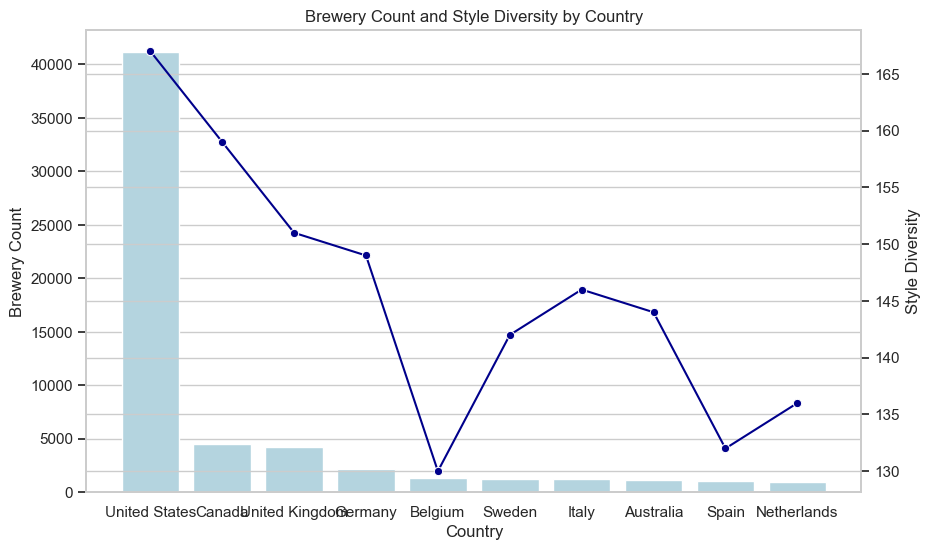

In [34]:
sns.set(style="whitegrid")

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Brewery Count
sns.barplot(x='country', y='Brewery_Count', data=top_brewery_countries, ax=ax1, color='lightblue')

# Line plot for Style Diversity
ax2 = ax1.twinx()
sns.lineplot(x='country', y='Style_Diversity', data=top_brewery_countries, ax=ax2, color='darkblue', marker='o')

ax1.set_title('Brewery Count and Style Diversity by Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Brewery Count')
ax2.set_ylabel('Style Diversity')

plt.show()

The United States leads significantly in brewery count (41,152) and style diversity (167). This suggests a highly developed and diverse beer industry, likely offering a wide range of beer experiences from mass-produced to craft and specialty beers.
Belgium and Germany, known for their beer culture, show a good balance of brewery count and style diversity (Belgium: 1,369 breweries, 130 styles; Germany: 2,131 breweries, 149 styles). This aligns with their reputation for quality and variety in beer production.
High brewery count and style diversity in countries like Canada and the UK also indicate thriving beer industries. The data reveals a correlation between a country's beer culture's maturity and its diversity in beer styles.

# Now let's look at the ratings by country
Some countries might excel in specific aspects, like the robust taste profiles of Belgian ales or the refined appearance of German lagers. This analysis will help in understanding which countries' beers are most favored by enthusiasts and critics alike.

In [35]:
ratings_copy = ratings_data.copy()

In [36]:
ratings_by_country_df = ratings_copy.groupby('country').agg(
    Average_Taste_Rating=('taste', 'mean'),
    Average_Aroma_Rating=('aroma', 'mean'),
    Average_Appearance_Rating=('appearance', 'mean'),
    Average_Palate_Rating=('palate', 'mean'),
    Average_Overall_Rating=('rating', 'mean')
).reset_index()

In [37]:
top_rated_countries = ratings_by_country_df.nlargest(10, 'Average_Overall_Rating')

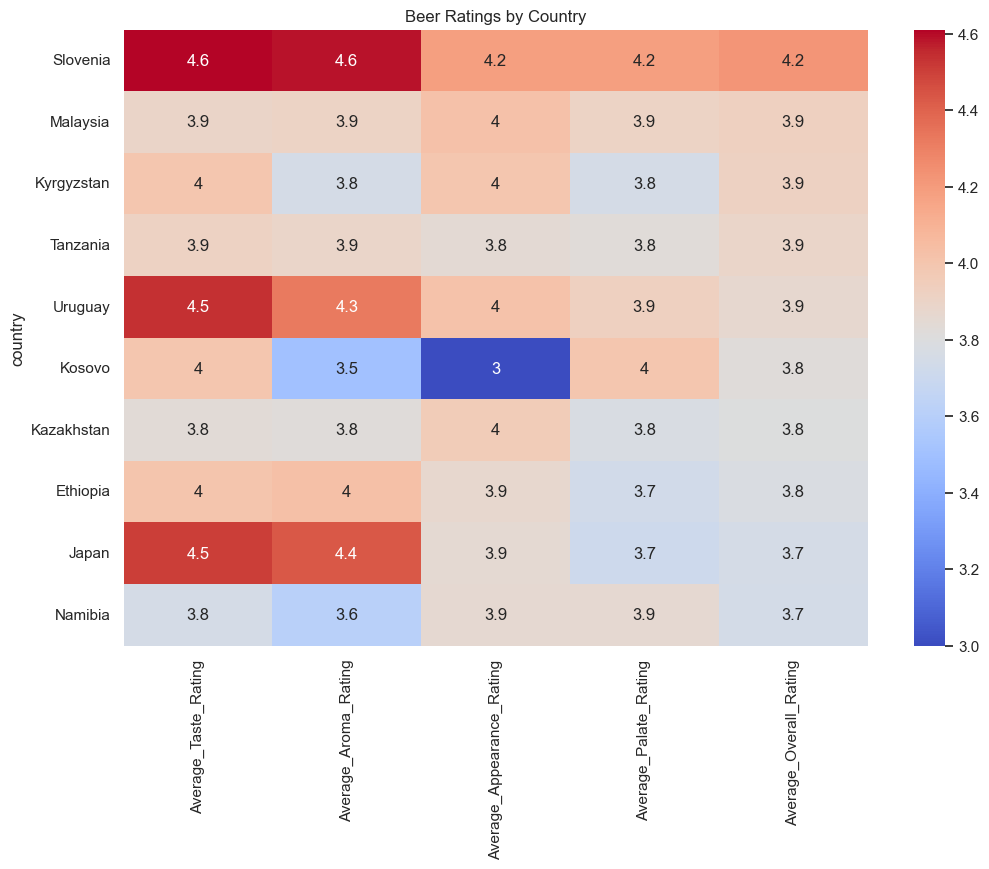

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(top_rated_countries.set_index('country'), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Beer Ratings by Country')
plt.show()

Slovenia, with high average ratings across taste, aroma, appearance, palate, and overall (around 4.6 for taste and aroma), suggests an exceptionally high quality of beer, potentially indicating a niche, high-quality beer market.
Japan's high ratings (average taste rating of 4.5) indicate a preference for quality and unique flavors in their beer industry.
The presence of countries like Malaysia and Tanzania with higher-than-expected ratings might suggest emerging markets with developing tastes or unique local beer styles gaining popularity.

# Let's now analyse the popular beer styles by country
The results might reflect traditional preferences, like the popularity of stouts in Ireland or IPAs in the United States, or could uncover emerging trends in global beer tastes.

In [39]:
ratings_copy = ratings_data.copy()

In [40]:
# Calculate the average rating and review count for each style
style_popularity = ratings_copy.groupby('style').agg(
    Average_Rating=('rating', 'mean'),
    Review_Count=('rating', 'count')
).reset_index()

# Select the top N styles based on review count or rating
N_styles = 10
top_styles = style_popularity.nlargest(N_styles, 'Review_Count')['style']

# Filter the original dataframe to include only the top styles
filtered_styles_df = ratings_copy[ratings_copy['style'].isin(top_styles)]

In [41]:
# Assuming 'popular_styles_df' has columns 'country' and 'rating'
top_countries = ratings_copy.groupby('country').size().nlargest(10).index

filtered_df = filtered_styles_df[filtered_styles_df['country'].isin(top_countries)]

# Group by country and style to find the most popular style in each country
country_style_popularity = filtered_df.groupby(['country', 'style']).agg(
    Average_Rating=('rating', 'mean'),
    Review_Count=('rating', 'count')
).reset_index()

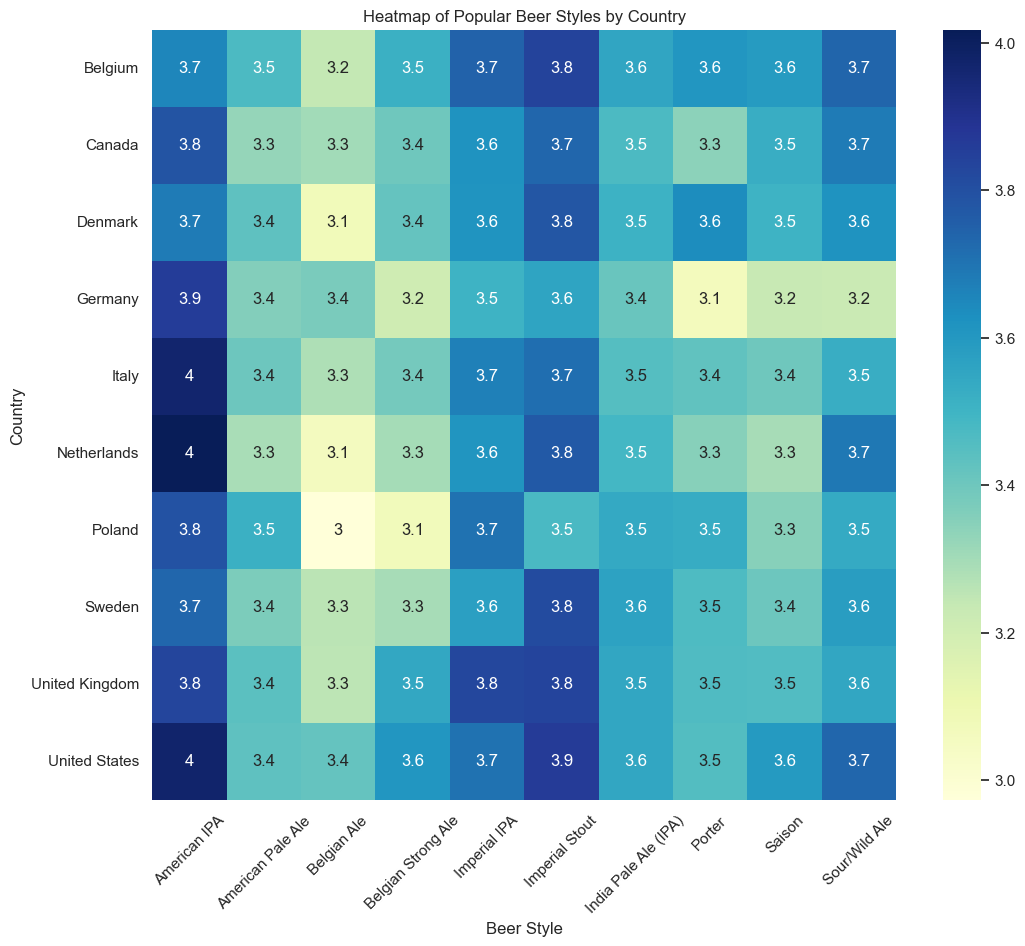

In [42]:
# Creating a pivot table for visualization
pivot_table = country_style_popularity.pivot_table(index='country', columns='style', values='Average_Rating')

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Popular Beer Styles by Country')
plt.ylabel('Country')
plt.xlabel('Beer Style')
plt.xticks(rotation=45)
plt.show()

The United States shows a diverse range of popular beer styles with high ratings, especially for American IPA (average rating of 3.98) and Imperial Stout (3.86). This diversity reflects the dynamic and innovative nature of the American beer market.
The UK and Belgium also show diversity in popular styles, with high ratings in categories like Imperial Stout and Belgian Strong Ale, reflecting their traditional strengths.
The data reflects a blend of traditional and modern styles, indicating a global trend towards variety and experimentation in beer production.

# Finally, let's try to find a correlation between breweries, diversity and ranking
An analysis of the correlation between the number of breweries, diversity of beer types, and overall beer ratings in each country is an insightful undertaking. This involves examining whether countries with more breweries and a wider range of beer styles tend to have higher overall ratings for their beers. Such a correlation, if present, could suggest that a vibrant, competitive brewing scene fosters higher quality and innovation in beer production.

In [43]:
ratings_copy = ratings_data.copy()

In [44]:
correlation_df = ratings_copy.groupby('country').agg(
    Brewery_Count=('beer_id', 'nunique'),
    Style_Diversity=('style', 'nunique'),
    Average_Overall_Rating=('rating', 'mean')
).reset_index()

In [45]:
top_correlation_countries = correlation_df[correlation_df['country'].isin(top_brewery_countries['country'])]

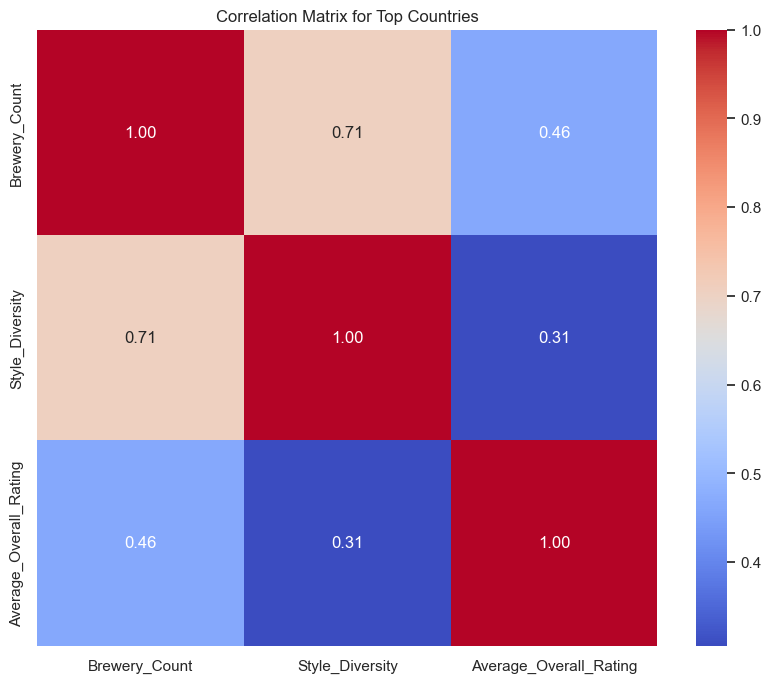

In [46]:
# Exclude non-numeric columns (like 'country') before calculating the correlation
numeric_cols = top_correlation_countries.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix on numeric columns only
corr_matrix = numeric_cols.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Top Countries')
plt.show()

Correlation Between Brewery Count and Style Diversity: 
The correlation coefficient is 0.707. This is a strong positive correlation, suggesting that countries with more breweries tend to also have a greater diversity of beer styles. This relationship implies that as the beer industry in a country expands in terms of the number of breweries, there is a parallel increase in the variety of beer styles produced. It indicates a thriving beer culture where expansion leads to innovation and variety.

Correlation Between Brewery Count and Average Overall Rating: 
The correlation coefficient is 0.464. This is a moderate positive correlation. It implies that countries with more breweries tend to have higher average overall ratings for their beers, although the relationship is not as strong as with style diversity. This could suggest that having more breweries contributes to better quality beers, possibly due to increased competition, a greater exchange of brewing techniques, or a wider selection for consumers.

Correlation Between Style Diversity and Average Overall Rating: 
The correlation coefficient is 0.306. This is a positive but relatively weak correlation. It indicates that a greater diversity of beer styles has some association with higher average overall ratings, but other factors may play a more significant role in determining beer quality. This could mean that simply having a wide variety of beer styles is not a strong predictor of overall beer quality as perceived by consumers or critics.